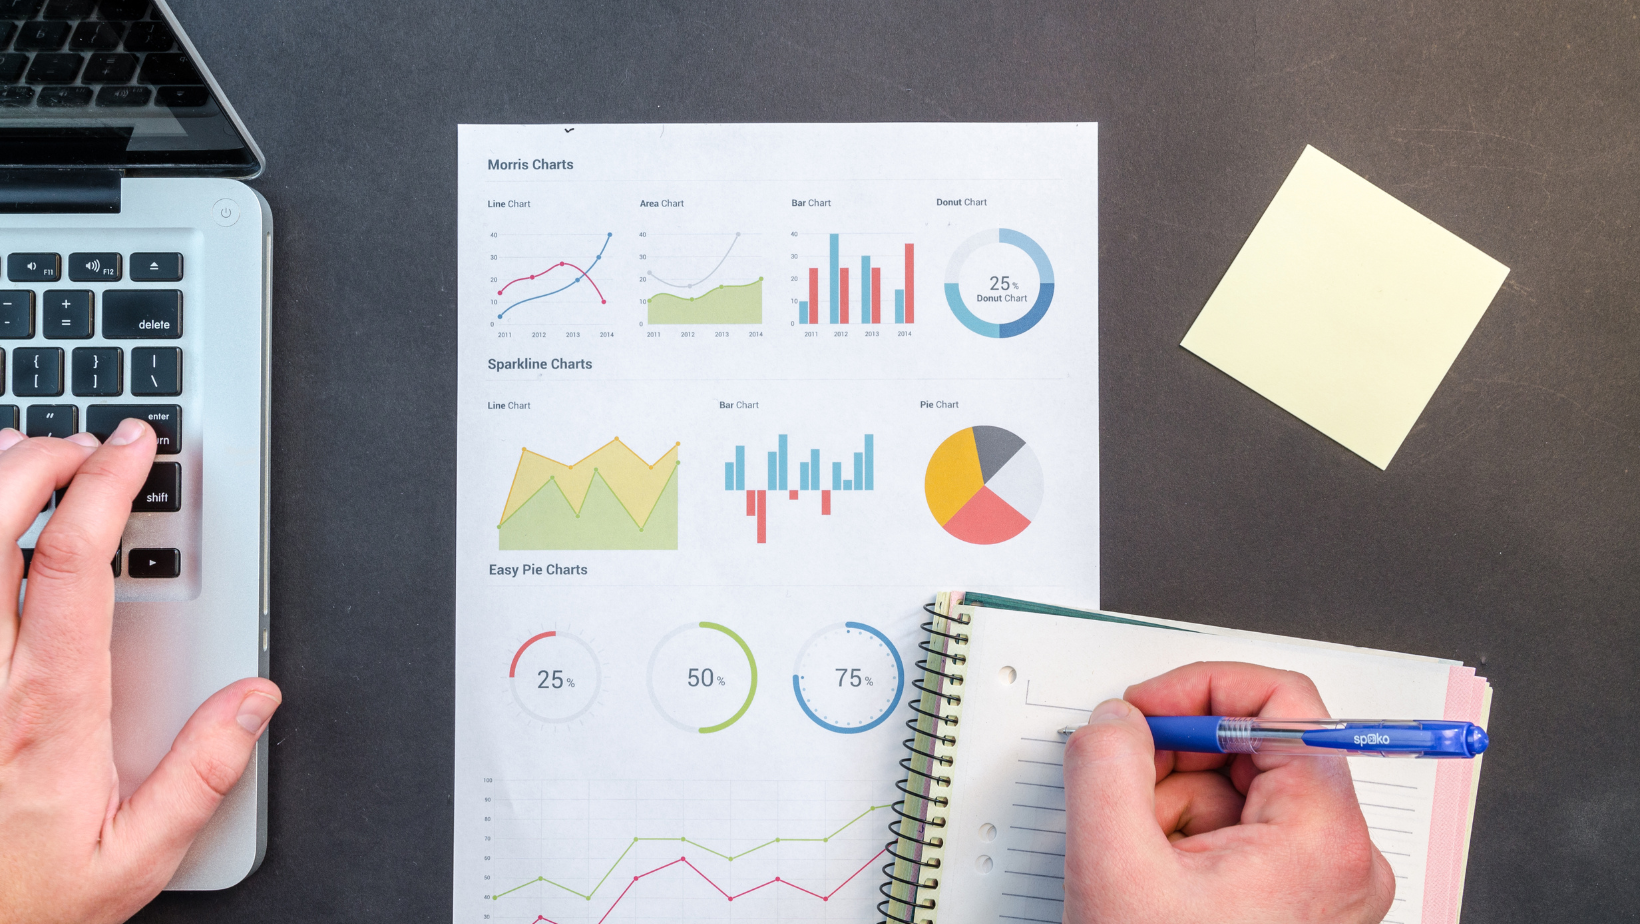

# ***Estratégias de Conversão:*** *Funil de Vendas e Avaliação A/A/B*

### ***Descrição do Projeto:***

*Em nossa startup gastronômica, embarcamos em uma jornada para explorar o comportamento do usuário no aplicativo de vendas de alimentos.*

*Ao analisar o funil de vendas, buscamos desvendar como os usuários alcançam a compra e identificar possíveis obstáculos nas fases anteriores.*

*Em seguida, conduziremos um teste A/A/B para otimizar o design, explorando a aceitação das novas fontes. Ao dividir os usuários em grupos de controle e teste, nosso objetivo é decidir qual conjunto de fontes proporciona a melhor experiência, guiando-nos na contínua busca pela excelência na interação do usuário.*

### ***Dados do Projeto:***

***Cada entrada de diário é uma ação do usuário ou um evento.***

- *EventName — nome do evento*
- *DeviceIDHash — dentificador de usuário exclusivo*
- *EventTimestamp — hora do evento*
- *ExpId — número do experimento: 246 e 247 são os grupos de controle, 248 é o grupo de teste*

# *Iniciando Projeto*

In [49]:
# importando bibliotecas
import pandas as pd
import numpy as numpy
from scipy import stats as st
import datetime as dt
import matplotlib.dates as mdates

import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objs as go

# definindo paleta de cores
pastel_light_blue = "#ADD8E6"
pastel_dark_blue = "#6A5ACD"
pastel_pink = "#FFB6C1"
pastel_orange = "#FFDDA0"
pastel_red = "#FF6347"
pastel_purple = "#D8BFD8"
pastel_green = "#98FB98"

# definindo
palette_colors = [pastel_light_blue, pastel_dark_blue, pastel_pink, pastel_orange, pastel_red, pastel_purple,pastel_green]
sns.set_context("notebook")
sns.set(rc={"axes.linewidth": .66})
sns.set(style="white", palette=palette_colors)


In [3]:
# carregando arquivo
path = 'C:/my_workspace/Github/Project_Sales_Funnel_and_AAAB_Test/data/'
df = pd.read_csv(path + 'logs_exp_us.csv', sep='\t')

*Primeiras informações dos nossos dados.*

In [4]:
df.info()
df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 244126 entries, 0 to 244125
Data columns (total 4 columns):
 #   Column          Non-Null Count   Dtype 
---  ------          --------------   ----- 
 0   EventName       244126 non-null  object
 1   DeviceIDHash    244126 non-null  int64 
 2   EventTimestamp  244126 non-null  int64 
 3   ExpId           244126 non-null  int64 
dtypes: int64(3), object(1)
memory usage: 7.5+ MB


,EventName,DeviceIDHash,EventTimestamp,ExpId
0,MainScreenAppear,4575588528974610257,1564029816,246
1,MainScreenAppear,7416695313311560658,1564053102,246
2,PaymentScreenSuccessful,3518123091307005509,1564054127,248
3,CartScreenAppear,3518123091307005509,1564054127,248
4,PaymentScreenSuccessful,6217807653094995999,1564055322,248


In [5]:
df.describe()

,DeviceIDHash,EventTimestamp,ExpId
count,2.441260e+05,2.441260e+05,244126.000000
mean,4.627568e+18,1.564914e+09,247.022296
std,2.642425e+18,1.771343e+05,0.824434
min,6.888747e+15,1.564030e+09,246.000000
25%,2.372212e+18,1.564757e+09,246.000000
50%,4.623192e+18,1.564919e+09,247.000000
75%,6.932517e+18,1.565075e+09,248.000000
max,9.222603e+18,1.565213e+09,248.000000


In [6]:
df.shape

(244126, 4)

*Temos mais de 240 mil linhas e somente 4 colunas.*

*Vamos analisar os nomes das colunas.*

In [7]:
df.columns

Index(['EventName', 'DeviceIDHash', 'EventTimestamp', 'ExpId'], dtype='object')

*Iremos transformar os nomes das colunas para lower case e renomeá-los.*

In [8]:
df.rename(columns= {'EventName': 'event', 'DeviceIDHash': 'id', 'EventTimestamp': 'ts', 'ExpId': 'group' }, inplace=True)

In [9]:
# conferindo
df.head()

,event,id,ts,group
0,MainScreenAppear,4575588528974610257,1564029816,246
1,MainScreenAppear,7416695313311560658,1564053102,246
2,PaymentScreenSuccessful,3518123091307005509,1564054127,248
3,CartScreenAppear,3518123091307005509,1564054127,248
4,PaymentScreenSuccessful,6217807653094995999,1564055322,248


*Iremos analisar coluna a coluna agora.*

In [10]:
df.group.value_counts(normalize=True)

248    0.351241
246    0.328945
247    0.319814
Name: group, dtype: float64

*O grupo 248 é o grupo de controle e chamaremos de B. Os grupos 246 e 247, serão A1 e A2.*

In [11]:
df['group'] = df['group'].replace({246: 'A1', 247: 'A2', 248: 'B'})

*Coluna event_name.*

In [12]:
df.event.value_counts(normalize=True)

MainScreenAppear           0.488293
OffersScreenAppear         0.191807
CartScreenAppear           0.175037
PaymentScreenSuccessful    0.140554
Tutorial                   0.004309
Name: event, dtype: float64

In [13]:
df.event.value_counts(normalize=True)

MainScreenAppear           0.488293
OffersScreenAppear         0.191807
CartScreenAppear           0.175037
PaymentScreenSuccessful    0.140554
Tutorial                   0.004309
Name: event, dtype: float64

*Quase 50% dos eventos são do tipo "MainScreenAppear". Eventos de acesso ao tutorial possuem menos de 1%.*

*Olhando formato de ts.*

In [14]:
df.ts.dtype

dtype('int64')

*Uma amostra dos dados.*

In [15]:
df.ts.value_counts(normalize=True)

1564670435    0.000037
1564935799    0.000037
1565017227    0.000033
1565176721    0.000033
1564911846    0.000033
                ...   
1564837824    0.000004
1564837843    0.000004
1564837844    0.000004
1564837845    0.000004
1565212517    0.000004
Name: ts, Length: 176654, dtype: float64

*Iremos tranformá-la para o formato correto.*

In [16]:
df['ts'] = pd.to_datetime(df['ts'], unit='s')

*Criando coluna date.*

In [17]:
df['date'] = df['ts'].dt.floor('1D')

*Removendo informações da coluna ts.*

In [18]:
df['ts'] = df['ts'].dt.strftime('%H:%M:%S')

*Conferindo.*

In [19]:
df.head()

,event,id,ts,group,date
0,MainScreenAppear,4575588528974610257,04:43:36,A1,2019-07-25
1,MainScreenAppear,7416695313311560658,11:11:42,A1,2019-07-25
2,PaymentScreenSuccessful,3518123091307005509,11:28:47,B,2019-07-25
3,CartScreenAppear,3518123091307005509,11:28:47,B,2019-07-25
4,PaymentScreenSuccessful,6217807653094995999,11:48:42,B,2019-07-25


*Coluna id.*

In [20]:
df.id.value_counts(normalize=True)

6304868067479728361    0.009454
197027893265565660     0.008205
4623191541214045580    0.007254
6932517045703054087    0.005931
1754140665440434215    0.005006
                         ...   
1473604074272762258    0.000004
4038665841336196550    0.000004
6471198426894625455    0.000004
8306004969579731119    0.000004
1083512226259476085    0.000004
Name: id, Length: 7551, dtype: float64

*Vamos agora procurar por duplicados.*

In [21]:
df.duplicated().sum()

413

*Calculando proporção.*

In [22]:
df.duplicated().sum() / df.shape[0]

0.0016917493425526163

*Vamos remover os duplicados e verificar a remoção.*

In [23]:
df.drop_duplicates(inplace=True)

df.duplicated().sum()

0

*Procurando por valores nulos.*

In [24]:
df.isna().sum()

event    0
id       0
ts       0
group    0
date     0
dtype: int64

*Sem valores nulos.*

*Verificando nosso df agora.*

In [25]:
df.head()

,event,id,ts,group,date
0,MainScreenAppear,4575588528974610257,04:43:36,A1,2019-07-25
1,MainScreenAppear,7416695313311560658,11:11:42,A1,2019-07-25
2,PaymentScreenSuccessful,3518123091307005509,11:28:47,B,2019-07-25
3,CartScreenAppear,3518123091307005509,11:28:47,B,2019-07-25
4,PaymentScreenSuccessful,6217807653094995999,11:48:42,B,2019-07-25


*Um gráfico para finalizar a processo de limpeza e tratamento dos dados.*

*Contagem de eventos em Barras.*

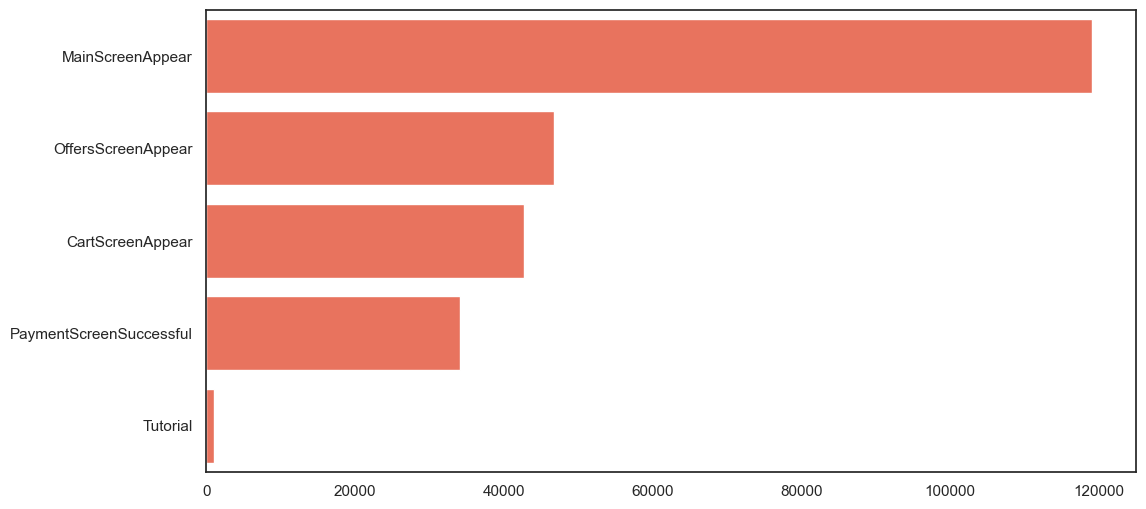

In [50]:
sns.set(style="white", palette=[pastel_red])
plt.figure(figsize=(12, 6))
sns.countplot(data=df, y='event' ,order=df['event'].value_counts().index)
plt.xlabel('')
plt.ylabel('')
plt.show()

*MainScreenAppear disparado, seguido de OffersScreenAppear e CartScreenAppear.*

***Overview:***
- *Mais de 244 mil linhas (rows) distribuídas em 4 colunas (fields)*
- *Alteramos os nomes das colunas*
- *Sem valores nulos, mas havia duplicados*
- *Removemos os duplicados que eram menos de 1% do df*
- *Na coluna group, renomeamos os grupos para: A1, A2 e B*
- *Deixamos a coluna ts (timestamp) em formato adequado aos dados*
- *Ainda separamos a data e criamos uma nova coluna chamada date.*

# *Iniciando Análise Exploratória dos Dados - EDA*